In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, string
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset, load_metric
from transformers import T5Tokenizer, DataCollatorForSeq2Seq, TFAutoModelForSeq2SeqLM
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords as nltk_stopwords
import re
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from tqdm import tqdm
import pickle

# Generating Abstractive Summaries by Fine-Tuning T5
The possible uses for automatic text summarization are innumerable. Many texts are long, and for various reasons we would prefer not to read a text or would like to know what a text is about before it is used. What is less obvious is that there are two types of automatically generated summaries: extractive and extractive. An extractive summary is one which consists of extracts from some text, and in that sense it is not really not automatically generated but found. An extractive summary model may take in a question, then predict the first and last index of text in some document to use as a summary. Put otherwise, it generates probability distributions over the length of some article for the start and end index, and takes the argmax of each to find the indices. This is a fairly standard task, but it limits the model to using as summaries already existing text. An abstractive summary is one using language generated by a model. It may generate probability distributions over sequences of texts to give an idea of what word should come next in a sequence. The next token can then be selected using methods discussed below. This is a more challenging task.

To put the problem as simply as possible, natural language problems are computationally intensive, and they become moreso as input sequences increase in length. They are also data-hungry. Natural language generation is also difficult, and it becomes more difficult as the length of output sequences increase. The problem gets worse considering recurrent neural networks. Recurrent neural networks struggle to learn long sequences, even LSTMs. Recurrent neural networks also update a hidden state in a sequential fashion, meaning they cannot be parallelized. All of the information from the sequence is ultimately contained in the hidden state.

In this notebook, a T5 model will be fine tuned to generate summaries based off of BBC problems. This method addresses all of the problems above. Abstract summarization remains computationally intensive and data hungry, but the T5 model used is pre-trained and has been trained on a large amount of data and for a large amount of time. That means that fine-tuning time is relatively very short and leads to a model that is superior to what can reasonably be trained on a consumer computer. A superior model means superior text generation. Additionally, T5 uses transformers. The crucial point of the transformer is that it uses attention. In an encoder-decoder model, attention at each timestep looks over all of the encoder timesteps - rather than just a final hidden state, generates a probability distribution and uses this to generate scores. Attention ultimately quantify which part of the encoder sequence is most relevant to each part of the decoder sequence. The bottom line is that attention not only greatly improves performance with respect to predictions but is also parallelizable, improving performance with respect to computation time.

# Load Data
The data consists of BBC articles and associated summaries. These articles are listed in various directories, according to the category of the article. To load the data, I walk through the directories and add each article and sumamry to a list.

In [3]:
article_texts = []
summary_texts = []
article_class = []

for paths, dir, files in os.walk('BBC News Summary'):
    for file in files:
        file_name = paths + '\\' + file
        topic = file_name.split('\\')[-2]
        doc_type = file_name.split('\\')[-3]
        with open(file_name, 'r') as f:
            if doc_type == 'News Articles':
                article_texts.append(' '.join(f.readlines()).replace('\n', ' ').strip().lower())
                article_class.append(topic)
            elif doc_type == 'Summaries':
                summary_texts.append(' '.join(f.readlines()).lower())

In [4]:
column_dict = {'Article': article_texts, 'Summary':summary_texts, 'Topic': article_class}
df = pd.DataFrame.from_dict(column_dict)
print('Dataframe shape: ', df.shape)
df.head()

Dataframe shape:  (2225, 3)


,Article,Summary,Topic
0,ad sales boost time warner profit quarterly...,timewarner said fourth quarter sales rose 2% t...,business
1,dollar gains on greenspan speech the dollar...,the dollar has hit its highest level against t...,business
2,yukos unit buyer faces loan claim the owner...,yukos' owner menatep group says it will ask ro...,business
3,high fuel prices hit ba's profits british a...,"rod eddington, ba's chief executive, said the ...",business
4,pernod takeover talk lifts domecq shares in...,pernod has reduced the debt it took on to fund...,business


# Split the Data
The data is split into testing and training sets.

In [5]:
X = df['Article'].values
y = df['Summary'].values

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Text Cleaning
A few steps are taken to clean the text. URLs are removed from both the articles and summaries. Special characters, i.e. those other than alphanumeric characters are removed from the articles. Stopwords, words that carry little or no meaning, are also removed from the articles. The logic behind the data cleaning if based on two principles. First, the article text should be as simple as possible. Second, the model should generate coherent summaries. Thus the articles are stripped of characters and words that do not contain information, but those things are left in the summaries because removing them makes the text less coherent.

In [7]:
def clean_strings(articles, summaries):
    '''
    Performs some basic cleaning functions on strings, as well as tokenizing them. From articles, URLs, stopwords, words consisting of 1 or 2 characters,
    and non-alphanumeric characters are removed. From summaries, URLs are removed. Parameters: articles, a list of string articles, and summaries,
    a list of string summaries.
    Returns: tokenized and cleaned summaries and strings.

    '''
    # Remove URLs, special characters and punctuation
    allowed_chars = string.ascii_letters+string.digits+' '
    articles_no_special_char = []
    summaries_no_url = []
    
    for i, article in enumerate(articles):
        clean_article = re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', article)
        clean_article = ''.join([char for char in clean_article if char in allowed_chars])

        clean_summary = re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', summaries[i])
        articles_no_special_char.append(clean_article)
        summaries_no_url.append(clean_summary)

    # Tokenization
    articles_tokenized = [word_tokenize(article) for article in articles_no_special_char]
    summaries_tokenized = [word_tokenize(summary) for summary in summaries_no_url]

    # Remove stopwords from articles and stem the words in the article
    stopwords = nltk_stopwords.words('english')

    articles_no_stopwords = []
    for article in articles_tokenized:
        article_no_stopwords = [tok for tok in article if tok not in stopwords]
        articles_no_stopwords.append(article_no_stopwords)
    return articles_no_stopwords, summaries_tokenized

x_train_tokenized, y_train_tokenized = clean_strings(x_train, y_train)
x_test_tokenized, y_test_tokenized = clean_strings(x_test, y_test)

# Alternate Text Lengths


In [8]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
def clean_strings(articles, summaries):
    '''
    Performs some basic cleaning functions on strings, as well as tokenizing them. From articles, URLs, stopwords, words consisting of 1 or 2 characters,
    and non-alphanumeric characters are removed. From summaries, URLs are removed. Parameters: articles, a list of string articles, and summaries,
    a list of string summaries. Note this may give a warning, but the cause of the warning is addressed below.
    Returns: tokenized and cleaned summaries and strings.

    '''
    # Remove URLs, special characters and punctuation
    allowed_chars = string.ascii_letters+string.digits+' '
    articles_no_special_char = []
    summaries_no_url = []
    
    for i, article in enumerate(articles):
        clean_article = re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', article)
        clean_article = ''.join([char for char in clean_article if char in allowed_chars])

        clean_summary = re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', summaries[i])
        articles_no_special_char.append(clean_article)
        summaries_no_url.append(clean_summary)

    # Add "summarize: " to articles, so the model knows what task to perform
    articles_no_special_char = ['summarize: ' + article for article in articles_no_special_char]


    # Tokenization
    articles_tokenized = tokenizer(articles_no_special_char)
    summaries_tokenized = tokenizer(summaries_no_url)

    # Remove stopwords from articles and stem the words in the article
    stopwords = tokenizer.encode(nltk_stopwords.words('english'))

    articles_no_stopwords = {'input_ids':[], 'attention_mask':[]}
    for sample_idx, article in enumerate(articles_tokenized['input_ids']):
        input_no_stopwords = []
        attention_mask_no_stopwords = []
        for tok_idx, token in enumerate(article):
            if token not in stopwords:
                input_no_stopwords.append(token)
                attention_mask_no_stopwords.append(articles_tokenized['attention_mask'][sample_idx][tok_idx])

        articles_no_stopwords['input_ids'].append(input_no_stopwords)
        articles_no_stopwords['attention_mask'].append(attention_mask_no_stopwords)
    return articles_no_stopwords, summaries_tokenized

x_train_tokenized, y_train_tokenized = clean_strings(x_train, y_train)
x_test_tokenized, y_test_tokenized = clean_strings(x_test, y_test)

Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors


# Text Lengths
Limiting text length will allow more efficient memory usage. Articles and summaries will be padded. So if there are a few articles or summaries that are unusually long, unless those outliers are removed, other articles or summaries will be padded to match the outliers' length. But since the outliers are by definition unusual, this padding is really just a memory loss with little practical gain in performance. As such, text lengths are examined to detect and discard outliers.

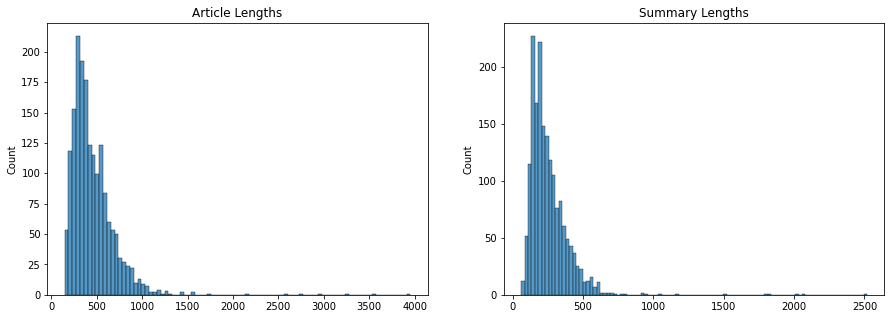

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
article_lengths = [len(article) for article in x_train_tokenized['input_ids']]
summary_lengths = [len(summary) for summary in y_train_tokenized['input_ids']]

sns.histplot(article_lengths, ax=axes[0])
axes[0].set_title('Article Lengths')
sns.histplot(summary_lengths, ax=axes[1])
axes[1].set_title('Summary Lengths')
plt.show()

In [10]:
article_threshold = 512
summary_threshold = 512

short_articles = len([article for article in x_train_tokenized['input_ids'] if len(article) <= article_threshold])
short_summaries = len([summary for summary in y_train_tokenized['input_ids'] if len(summary) <= summary_threshold])

num_articles = len(x_train_tokenized['input_ids'])
num_summaries = len(y_train_tokenized['input_ids'])

print(f'Approximately {np.round(100*short_articles/num_articles, decimals=2)}% articles are re shorter than the threshold of {article_threshold} tokens.')
print(f'Approximately {np.round(100*short_summaries/num_summaries, decimals=2)}% summaries are shorter than the threshold of {summary_threshold} tokens.')

Approximately 68.48% articles are re shorter than the threshold of 512 tokens.
Approximately 96.07% summaries are shorter than the threshold of 512 tokens.


Limiting articles to those with 512 tokens or less and summaries to those with 512 tokens or less result in losing  about ~32% of the training corpus.

In [11]:
def remove_long_texts(articles, summaries, max_article_len=article_threshold, max_summary_len=summary_threshold):
    '''
    Removes articles and summaries longer than given lengths. Pads shorter articles to the maximum permissible length.
    Parameters: articles, a dictionary of encoded articles and their attention masks; summaries, a dictionary of encoded summaries and their attention masks; max_article_len, 
    the longest permissible article; max_summary_len, the longest permissible summary.
    Returns: short articles and short summaries, those articles and summaries below the maximum allowed lengths.
    '''
    short_articles = {'input_ids':[], 'attention_mask':[]}
    short_summaries = []
    for i, article in enumerate(articles['input_ids']):
        # Select the short articles and summaries
        if len(article) < max_article_len and len(summaries['input_ids'][i]) < max_summary_len:
            current_article_mask = articles['attention_mask'][i]
            current_summary_ids = summaries['input_ids'][i]

            # Pad the article and summary to the max length, if selected
            while len(article) < max_article_len:
                article.append(0)
                current_article_mask.append(0)

            while len(current_summary_ids) < max_summary_len:
                current_summary_ids.append(0)

            short_articles['input_ids'].append(article)
            short_articles['attention_mask'].append(current_article_mask)

            short_summaries.append(current_summary_ids)

        

    return short_articles, short_summaries
    
x_train_padded, y_train_padded = remove_long_texts(x_train_tokenized, y_train_tokenized)
x_test_padded, y_test_padded = remove_long_texts(x_test_tokenized, y_test_tokenized)

# Encode for T5
The model requires numeric inputs, not text inputs. While the T5 model will use its own embeddings, it still needs numeric inputs initially. As such the text is encoded. Each text is first tokenized, that is, broken down into numeric parts. Each token is then converted to a corresponding number. These sequences of numbers are the input ids. As discussed above, the texts will be padded to the same length. The "padding" consists of padding tokens. These tokens do not contain any meaning by definition. As such, the model should not consider them when calculating attention scores on articles, since attention scores highlight important features in the text. To ensure the model ignores padding tokens, attention masks are generated to identify which tokens are padding tokens. The result is that each text, will be converted to a sequence of integers, the input ids, and the articles will also be given attention masks.

In [12]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
train = tokenizer(list(x_train), padding='longest', max_length=article_threshold, truncation=True)
test = tokenizer(list(x_test), padding='longest', max_length=article_threshold, truncation=True)

# Don't need to attention maks the targets
y_train = tokenizer(list(y_train), padding='longest', max_length=summary_threshold)["input_ids"]
y_test = tokenizer(list(y_test), padding='longest', max_length=summary_threshold)["input_ids"]

## Define Model and Create Tensorflow Dataset
This step loads the pretrained small T5 model. It also converts the data into a more useful format.

In [13]:
model = TFAutoModelForSeq2SeqLM.from_pretrained('t5-small')
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors='tf')

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [14]:
x_train_padded['labels'] = y_train_padded
x_test_padded['labels'] = y_test_padded

train_ds = Dataset.from_dict(x_train_padded)
test_ds = Dataset.from_dict(x_test_padded)

In [15]:
train_dataset = train_ds.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=4
)

test_dataset = train_ds.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=4
)

# Fine Tuning Model
The model if fine tuned on the training data below. That is to say, all of the layers are trainable, but a fairly low learning rate is learned. An early stopping callback is used to monitor the training process. This callback will automatically stop training if the model begins to learn too slowly.

In [16]:
model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (TFSharedEmbeddings)  multiple                 16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  18881280  
                                                                 
 decoder (TFT5MainLayer)     multiple                  25175808  
                                                                 
Total params: 60,506,624
Trainable params: 60,506,624
Non-trainable params: 0
_________________________________________________________________


In [17]:
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)

model.compile(optimizer=Adam(1e-5))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=300, callbacks=es)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/300
304/304 [==============================] - 108s 324ms/step - loss: 3.6567 - val_loss: 0.8746
Epoch 2/300
304/304 [==============================] - 96s 317ms/step - loss: 1.2989 - val_loss: 0.6831
Epoch 3/300
304/304 [==============================] - 97s 319ms/step - loss: 0.8606 - val_loss: 0.5966
Epoch 4/300
304/304 [==============================] - 97s 319ms/step - loss: 0.7357 - val_loss: 0.5457
Epoch 5/300
304/304 [==============================] - 97s 320ms/step - loss: 0.6691 - val_loss: 0.5002
Epoch 6/300
304/304 [==============================] - 97s 320ms/step - loss: 0.6152 - val_loss: 0.4642
Epoch 7/300
304/304 [==============================] - 97s 320ms/step - loss: 0.5730 - val_loss: 0.4334
Epoch 8/300
304/304 [==============================] - 98s 323ms/step - loss: 0.5375 - val_loss: 0.4087
Epoch 9/300
304/304 [==============================] - 97s 320ms/step - loss: 0.5085 - val_loss: 0.3872
Epoch 10/300
304/304 [==============================] - 97s 320

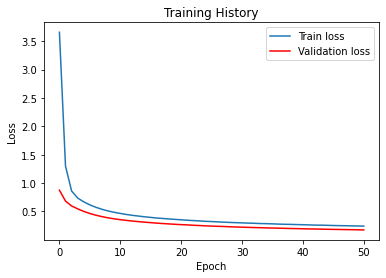

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_loss))

sns.lineplot(x=epochs, y=train_loss)
sns.lineplot(x=epochs, y=val_loss, color='red')
plt.legend(labels=['Train loss', 'Validation loss'])
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Generate Text
The trained model is ready to generate text. Inputs to the model need to be prepared exactly the same way as the training articles, which is to say, they need to be cleaned and encoded the same way. Then, they are ready to be put into the model. The model then generates a summary for each article using a beam search.

A beam search is best understood by contrasting it to a simple greedy search. A greedy algorithm is one that chooses the best option at each time step, without any regard for the bigger picture. So generating text in the simplest greedy fashion means choosing the next most likely token given the tokens made so far. This, however, will not necessarily mean generating the most optimal sequence overall. Additionally, it can also lead to repeating sequences of text.

The beam search seeks to address this problem without searching through every possible sequence of text. A beam search with beam size k - essentially the number of sequences to consider at each step - proceeeds as follows:

1. Generate a probability distribution over the vocabulary with some initialization token.
2. Select the k highest probability tokens.
3. For each of those k tokens, generate a probability distribution over the vocabulary.
4. Out of all of the possible sequences (a total of k * the number of tokens in the vocabulary), choose the k with the highest probability.
5. Repeat in a similar fashion, finding the k most likely sequences, until some end condition is met, ex. an end token is generated or a maximum length is reached.

The implementation used below additionally allows the model to prevent the repetition of n-grams of a certain size or above from being repeated within a sumamry.

This algorithm allows a number of sequences to be explored and prevents characters from being repeated while requiring far less computational power than an exhaustive search. However, as with any algorithm that generates text in a probablistic fashion, it is really only an approximation of how natural languages is actually generated.

In [19]:
def process_text(input_text):
    '''
    Cleans text to be used as model inputs by removing URLs, characters that are not alphanumeric, and stopwords.
    Parameters: input_text, a list of strings.
    Returns: list of clean strings.
    '''
    # Remove URLs, special characters and punctuation
    allowed_chars = string.ascii_letters+string.digits+' '+'\<' +'\>'
    articles_no_special_char = []
    
    for i, article in enumerate(input_text):
        clean_article = re.sub('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', article)
        clean_article = ''.join([char for char in clean_article if char in allowed_chars])

        articles_no_special_char.append(clean_article)

    # Add "summarize: " to articles, so the model knows what task to perform
    articles_no_special_char = ['summarize: ' + article for article in articles_no_special_char]

    # Tokenization
    articles_tokenized = tokenizer(articles_no_special_char, padding=True)

    # Remove stopwords from articles and stem the words in the article
    stopwords = tokenizer.encode(nltk_stopwords.words('english'))

    articles_no_stopwords = {'input_ids':[], 'attention_mask':[]}
    for sample_idx, article in enumerate(articles_tokenized['input_ids']):
        input_no_stopwords = []
        attention_mask_no_stopwords = []
        for tok_idx, token in enumerate(article):
            if token not in stopwords:
                input_no_stopwords.append(token)
                attention_mask_no_stopwords.append(articles_tokenized['attention_mask'][sample_idx][tok_idx])

        articles_no_stopwords['input_ids'].append(input_no_stopwords)
        articles_no_stopwords['attention_mask'].append(attention_mask_no_stopwords)
    return articles_no_stopwords

In [20]:
a = model.generate(K.constant(test_ds['input_ids'][:2], dtype=tf.int64), num_beams=5, no_repeat_ngram_size=3, max_length=512)

In [21]:
tokenizer.batch_decode(a)

['<pad> duran duran are currently promoting the albums second single what happens tomorrow, simon le bon said earlier this year that the group were not trying to update their sound too much.the show airs on tuesday and will feature a studio performance behind the scenes footage and fan interviews.the band recently released a new album astronaut, the first from the original lineup since 1983.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>',
 '<pad> musicians groups are to tackle us visa regulations which are blamed for hindering british acts\' chances of succeeding across the atlantic, a singer hoping to perform in the us can expect to pay 

In [33]:
def generate_in_batches(input_text, decode_batch_size=2, max_length=summary_threshold, n_beams=5, no_repeat_ngram_size=3):
    '''
    Generates summaries based on a list of text. This function takes in a list of text of arbitrary length and generates summaries in batches, for memory reasons.
    Pameters: input texts, a list of lists; decode_batch_side, the number of sequences to summarize at a time; max_length, the maximum summary length; n_beams, the number of beams
    to use when performing the beam search to generate texts; and no_repeat_ngram_size, the size of an n-gram below whjich n-grams cannot be repeated.
    Returns: a list of encoded summaries.
    '''
    generated_sequences = []
    old_decode_batch_size = 0
    i = decode_batch_size
    pbar = tqdm(total=len(input_text)/decode_batch_size)
    with pbar:
        while i <= len(input_text) + decode_batch_size -1:
            #input_tensors = tokenizer(K.constant(input_text[old_decode_batch_size: i], dtype=tf.int64), return_tensors='tf', padding="longest", max_length=article_threshold, truncation=True)['input_ids']
            generated_sequence_ids = model.generate(K.constant(input_text[old_decode_batch_size: i], dtype=tf.int64), num_beams=n_beams, no_repeat_ngram_size=no_repeat_ngram_size, max_length=max_length)
            generated_sequences.extend(generated_sequence_ids)
            old_decode_batch_size = i
            i += decode_batch_size
            pbar.update(1)

    return generated_sequences
gen_seq = generate_in_batches(test_ds['input_ids'], 2)

100%|██████████| 151/151.0 [49:31<00:00, 19.68s/it]


In [34]:
# Save the generated sequences
pickle.dump(gen_seq, open('generated_sequence_ids.p', 'wb'))

# Evaluation
The models are evaluated using the ROUGE score. ROUGE scores essentially measure the overlap between two sequences of text, here, reference and generated summaries. Here, ROUGE-1, ROUGE-2, and ROUGE-N scores are used. These can be defined simultaneously by considering the ROUGE-N score, which is the ROUGE score considering N grams.

The ROUGE-N score quantifies the number of N-grams found in both the reference and generated summaries. The score is calculated for each reference/generated pair. Really it consists of three scores, the precision, recall, and f-score, each of which corresponds to its more traditional classification analogue. Specifically, these are defined as follows:

$\text{ROUGE-N Precision} = \dfrac{\text{N-grams co-occuring in ground truth and generated summaries}}{\text{total N-grams in the generated summary}}$

$\text{ROUGE-N Recall} = \dfrac{\text{N-grams co-occuring in ground truth and generated summaries}}{\text{total N-grams in the ground truth summary}}$

Put more conceptually, the precision reports the fraction of n-grams from the generated summary that are also in the ground truth summary, and the recall reports the fraction of n-grams from the ground truth summary that were predicted by the model. The f-score is the harmonic mean of the precision and recall.

ROUGE-1 and ROUGE-2 are simply the scores where the n-grams are unigrams or bigrams - or single words and pairs for words, respectively.

ROUGE-L is slightly different. The "L" stands for "longest common subsequence," which is simply the length of the longest identical consecutive sequences of text in each text. This number is divided by the unigrams in the generated or ground truth summaries, depending on whether the precision or recall is returned.

Note that for each score, the model returns a low, mid, and high score. Recall that ROUGE calculates scores for each pair of generated and ground truth summaries, then aggregates them. The mid score is the mean score. The low and high scores represent the lower and upper bounds for a 95% confidence interval, respectively.


ROUGE scores, as many NLP metrics, are imperfect. There are three notable limitations. First, it considers common words, not similarity of meaning. So "Apple's stock fell this quarter" will take a score penalty if the reference summary is "The company's stock fell this quarter," even if the former conveys the meaning of an article better. Potential ways to mitigate this include stemming and lemmatizing. Here, stemming is used, which reduces a word to its stem, such as "running" to "run" or "painted" to "paint." Second, the score does not measure the coherence of the output, just commonly found n-grams. This is addressed by looking at longer n-grams or the ROUGE-L score. However, longer n-grams are generally less likely to be predicted. Third, the metrics do not check for the substantive accuracy of the summary, that is, they do not directly convey whether the summary accurately conveys the messaage of the text.

In [35]:
generated_summaries = tokenizer.batch_decode(gen_seq, skip_special_tokens=True)
reference_summaries = tokenizer.batch_decode(y_test_padded, skip_special_tokens=True)

In [36]:
rouge = load_metric('rouge')
rouge_score_dict = rouge.compute(predictions=generated_summaries, references=reference_summaries, use_stemmer=True, rouge_types=['rouge1', 'rouge2', 'rougeL'])

In [37]:
rouge_score_df_dict = {'precision':[], 'recall':[], 'fscore':[], 'score type':[], 'percentile':[]}
for key in rouge_score_dict:
    scores = np.array(rouge_score_dict[key])
    rouge_score_df_dict['score type'].extend([key]*3)
    rouge_score_df_dict['percentile'].extend(['2.5%', '50%', '97.5%'])
    rouge_score_df_dict['precision'].extend(scores[:,0])
    rouge_score_df_dict['recall'].extend(scores[:,1])
    rouge_score_df_dict['fscore'].extend(scores[:,2])
rouge_score_df = pd.DataFrame.from_dict(rouge_score_df_dict)
rouge_score_df

,precision,recall,fscore,score type,percentile
0,0.637862,0.464221,0.527241,rouge1,2.5%
1,0.655601,0.479792,0.538982,rouge1,50%
2,0.671312,0.495051,0.550948,rouge1,97.5%
3,0.464603,0.338775,0.383290,rouge2,2.5%
4,0.484352,0.356066,0.398916,rouge2,50%
5,0.503835,0.372844,0.414773,rouge2,97.5%
6,0.443004,0.321395,0.364636,rougeL,2.5%
7,0.458545,0.333855,0.375822,rougeL,50%
8,0.474951,0.347085,0.387774,rougeL,97.5%


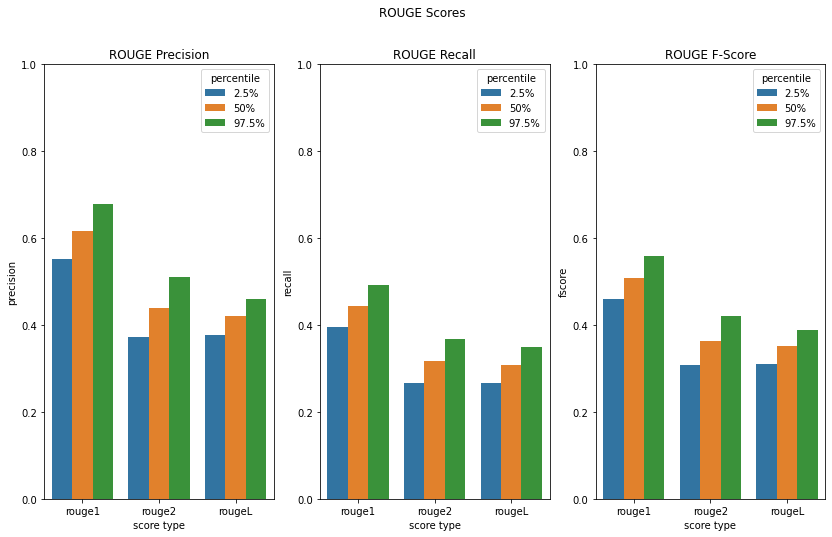

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8), sharey=True)
axes[0].set_ylim([0, 1])

sns.barplot(x='score type', y='precision', hue='percentile',  data=rouge_score_df, ax=axes[0])
axes[0].set_title('ROUGE Precision')

sns.barplot(x='score type', y='recall', hue='percentile',  data=rouge_score_df, ax=axes[1])
axes[1].set_title('ROUGE Recall')
axes[1].yaxis.set_tick_params(labelbottom=True)


sns.barplot(x='score type', y='fscore', hue='percentile',  data=rouge_score_df, ax=axes[2])
axes[2].set_title('ROUGE F-Score')
axes[2].yaxis.set_tick_params(labelbottom=True)


plt.suptitle('ROUGE Scores')
plt.show()

In [29]:
ROUGE_means = rouge_score_df[rouge_score_df['percentile'] == '50%'][rouge_score_df.columns[:-1]].set_index('score type')
print('Below are the mean values for each ROUGE score:')
ROUGE_means

Below are the mean values for each ROUGE score:


,precision,recall,fscore
score type,,,
rouge1,0.615891,0.443066,0.508465
rouge2,0.438793,0.316902,0.363555
rougeL,0.420132,0.308472,0.350711


The following are clear from the ROUGE scores
* Most unigrams and bigrams in the generated summaries are also in the reference summaries, but the opposite is not true, and the difference is substantial.
* The model's ROUGE-1 score is substantially higher than the other scores.
* The high, median, and low score generally do not have much spread between them.

Put more conceptually, the ROUGE score suggests that the model generates summaries that contain relevant information, but those summaries may leave out relevant information compared to the reference summaries. This could potentially come down to differences in length between generated and reference summary length since. Additionally, the model's ability to generate useful summaries is superior when looking at unigrams rather than sequences of other lengths. This is an intuitively reasonable result, given generating any one word is probably more likely than generating any sequence of more than one word. Finally, none of the summaries in the test set is far superior or far inferior to any other, which is a desirable result.

## Examples
Given ROUGE'S limitations, it is crucial to examine summaries, rather than just looking at scores.

In [30]:
def format_summary(summary):
    '''
    Removes corrects spacing around punctuation, removes double spaces, and capitalizes "i."
    Parameters: a summary, which is a string of text
    Returns: a formatted summary.
    '''
    summary = re.sub('([.,!?()])', r' \1 ', summary)
    summary = re.sub(r'\s([?:.,!"\'\'](?:\s|$))', r'\1', summary)
    summary = summary.replace('  ', ' ').strip()
    summary = '. '.join(map(lambda x: x.strip().capitalize(), summary.split('.'))).replace(' i ', ' I ')
    return summary

In [38]:
# Shows the generated and reference summaries indexed by the indices the list summaries_to_generate
summaries_to_generate = [0, 100, 200]
print(f'Below are {len(summaries_to_generate)} generated samples and their associated reference summaries.')
for pair_count, summary_idx in enumerate(summaries_to_generate):
    print(f'***********************Pair #{pair_count+1}***********************')
    print('Generated summary:')
    print(format_summary(generated_summaries[summary_idx]))
    print('\nReference summary:')
    print(format_summary(reference_summaries[summary_idx]))
    print('\n')

Below are 3 generated samples and their associated reference summaries.
***********************Pair #1***********************
Generated summary:
Duran duran are currently promoting the albums second single what happens tomorrow, simon le bon said earlier this year that the group were not trying to update their sound too much. The show airs on tuesday and will feature a studio performance behind the scenes footage and fan interviews. The band recently released a new album astronaut, the first from the original lineup since 1983. 

Reference summary:
We just really wanted to make a great duran duran album, " said keyboard player nick rhodes. Chart stars duran duran are to appear in a vh1 special in the us including interviews and concert footage. Simon le bon said earlier this year that the group were not trying to update their sound too much. Le bon also said the five members were getting on very well. "we wouldn't want to lose them [older fans] by trying too hard by trying to connect w

As can be seen above, the summariees are generally comprehensible, and there is some overlap between the spans of text contained. Some of the issues suggested by the ROUGE score are shown.  The first generated sample could be more coherent.The second generated summary contains useful information, but its corresponding reference contains more.

# Conclusion
A T5 model was fine-tuned on articles from BBC to predict their respective summaries.